In [13]:
# %%
import torch 
import torch.nn as nn

from functools import reduce
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

In [42]:

class PTLModule(pl.LightningModule):
    def __init__(self,
                batch_size=16,
                learning_rate=0.00001,
                n=6,):
        super().__init__(
           
        )
        self.save_hyperparameters()
        self.emb=nn.Embedding(1000, 32)
        self.layer1 = nn.Linear(32, 128)
        self.layer2 = nn.Linear(128, 64)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.batch_size=batch_size
        self.learning_rate=learning_rate
        self.n=n
     
        self.loss=torch.nn.CrossEntropyLoss(reduction='mean')
        torch.autograd.set_detect_anomaly(True)

       
    def forward(self, x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        return x
    def setup(self, stage):
        self.train_dataset = torch.utils.data.TensorDataset(torch.randint(0, 1000, (10000,)))
    def calculate_loss(self,*Args):

        return 1- torch.sqrt(torch.abs(torch.sum(reduce(torch.add,[torch.pow(arg,2).view(*list([1]*i+[arg.shape[0]]+[1]*(len(Args)-1-i)+[-1])) for i,arg in enumerate(Args)]).sub_(
                            torch.pow(reduce(torch.add,[arg.view(*list([1]*i+[arg.shape[0]]+[1]*(len(Args)-1-i)+[-1])) for i,arg in enumerate(Args)]),2),alpha=1/len(Args)),dim=-1)))


    def train_dataloader(self,batch_size=32):
      
        import torch.utils.data.dataloader as dataloader


        return dataloader.DataLoader(self.train_dataset,batch_size=self.batch_size,shuffle=True,num_workers=8,drop_last=True)
    def training_step(self, batch, batch_idx):

        x=self.emb(batch[0]) # should be Bxf 
        nx=[self(x+torch.randn_like(x))]*self.n # should be Bxf

        logits=torch.mul(torch.nan_to_num(self.calculate_loss(*nx)),self.logit_scale.exp())

        labels=torch.ones_like(batch[0],dtype=torch.float)
        while len(labels.shape)<len(logits.shape):
            labels=torch.diag_embed(labels)
        labels=torch.nan_to_num(labels)

        loss = self.loss(logits, labels)
        self.log("loss",loss,enable_graph=False)
        return  {"loss":loss, "labels":batch[0], "embs":nx[0]}  

    def training_epoch_end(self, outputs):

        alllabels=torch.cat([x['labels'] for x in outputs],dim=0)
        allembs=torch.cat([x['embs'] for x in outputs],dim=0)
 
        from sklearn.linear_model import LogisticRegression

        reg =LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=0, n_jobs=-1)
        reg.fit(allembs.detach().cpu().numpy(), alllabels.detach().cpu().numpy())
        
        self.log("score",reg.score(allembs.detach().cpu().numpy(), alllabels.detach().cpu().numpy()),on_step=False,on_epoch=True,prog_bar=True,logger=True)
     
            
    def configure_optimizers(self):
        
        optimizer = torch.optim.AdamW(
            [p for p in self.parameters()], lr=self.hparams.learning_rate, eps=10e-8,
         
            )
        return [optimizer]



from functools import reduce
class PTLModuleStock(PTLModule):
    def training_step(self, batch, batch_idx):
     
        x=self.emb(batch[0]) # should be Bxf 
        nx=[self(x+torch.randn_like(x))]*self.n # should be Bxf
        loss=reduce(torch.add,[self.loss(item@ x.T *self.logit_scale.exp(),torch.arange(batch[0].shape[0],device=self.device)) for x in nx  for item in nx])
     
        self.log("loss",loss,enable_graph=False)
        return  {"loss":loss, "labels":batch[0], "embs":nx[0]}  
    




In [43]:

#we're going to create some cool graphs, each with epochs : score for each of the 6 models and for each method. 
results={n:{ i:{} for i in range(17)} for n in range(2,14)}

for n in range(2,14):
   
    model=PTLModule(n=n)

    trainer = Trainer(
        gpus=1,
        max_epochs=20,
        logger=TensorBoardLogger("tb_logs"),
        auto_scale_batch_size="binsearch",
        auto_lr_find=False,
        #auto_select_gpus=True,
    )
    try:

        trainer.tune(model)

        trainer.fit(model)
        #set results n i to be the list of scores
        results[n][5]=model.trainer.logged_metrics
    except Exception as e:
        print(e)
        results[n][5]=None


for n in range(2,14):
    #do benchmark first
    model=PTLModuleStock(n=n)
    trainer = Trainer(
        gpus=1,
        max_epochs=20,
        logger=TensorBoardLogger("tb_logs"),
        auto_scale_batch_size="binsearch",
        auto_lr_find=False)
    try:
        trainer.tune(model)

        trainer.fit(model)
        #set results n i to be the list of scores
        results[n]["stock"]=model.trainer.logged_metrics
    except Exception as e:
        print(e)
        results[n]["stock"]=None

#save results
import pickle
with open("base-v-.pkl","wb") as f:
    pickle.dump(results,f)
    


/home/user/miniconda3/envs/open-ce/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/user/miniconda3/envs/open-ce/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/user/miniconda3/envs/open-ce/lib/python3.9/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float3

Function 'SqrtBackward0' returned nan values in its 0th output.


`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 2 succeeded, trying batch size 4
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 4 succeeded, trying batch size 8
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 8 succeeded, trying batch size 16
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 16 succeeded, trying batch size 32
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 32 succeeded, trying batch size 64
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 64 succeeded, trying batch size 128
`Trainer.fit` stopped: `max_steps=3` reached.
Batch size 128 succeeded, trying batch size 256
/home/user/miniconda3/envs/open-ce/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
/home/user/miniconda3

Epoch 0: 100%|██████████| 39/39 [00:04<00:00,  8.06it/s, loss=0, v_num=87]

/home/user/miniconda3/envs/open-ce/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/home/user/miniconda3/envs/open-ce/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
/home/user/miniconda3/envs/open-ce/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/user/miniconda3/envs/open-ce/lib/python3.9/sit ...
  rank_zero_warn(
GPU available: True (cuda), used: T

Epoch 0: 100%|██████████| 39/39 [00:15<00:00,  2.51it/s, loss=0, v_num=87]


[None, {'loss': tensor(-0.), 'score': tensor(0.9184, dtype=torch.float64)}, None, {'loss': tensor(-0.), 'score': tensor(0.9156, dtype=torch.float64)}, {'loss': tensor(-0.), 'score': tensor(0.9136, dtype=torch.float64)}, {'loss': tensor(-0.), 'score': tensor(0.9165, dtype=torch.float64)}, None, {'loss': tensor(-0.), 'score': tensor(0.9207, dtype=torch.float64)}, {'loss': tensor(-0.), 'score': tensor(0.9180, dtype=torch.float64)}, {'loss': tensor(-0.), 'score': tensor(0.9200, dtype=torch.float64)}, {'loss': tensor(-0.), 'score': tensor(0.9155, dtype=torch.float64)}, {'loss': tensor(-0.), 'score': tensor(0.9141, dtype=torch.float64)}]
(3, 5, 6, 7, 9, 10, 11, 12, 13) (0.9184, 0.9156156156156157, 0.9136, 0.9165, 0.9206682673069227, 0.918, 0.92, 0.9155, 0.9140914091409141)


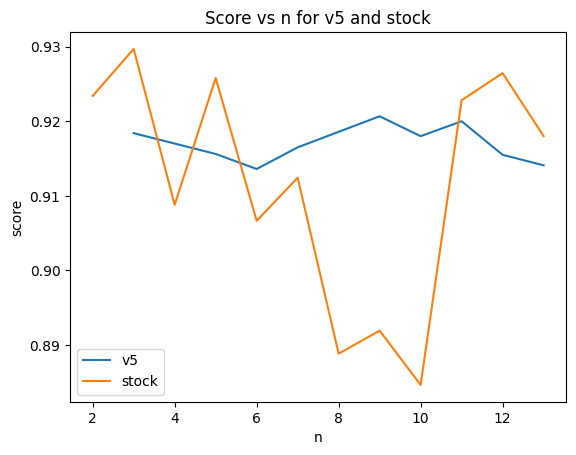

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import pickle
with open("base-v-.pkl","rb") as f:
    base=pickle.load(f)
#pickle.load("base-v-5.pkl")
stockscores=[]
scores=[]
for n in base:
   
    scores.append(base[n][5])
    stockscores.append(base[n]["stock"])


print(scores)
scoresv5=[(i+2,s["score"].item()) for i,s in enumerate(scores) if s is not None]
scoresstock=[(i+2,s["score"].item()) for i,s in enumerate(stockscores) if s is not None]
print(*zip(*scoresv5))
#plot n against score for both 
plt.plot(*zip(*scoresv5),label="v5")
plt.plot(*zip(*scoresstock),label="stock")

plt.legend()
plt.xlabel("n")
plt.ylabel("score")
plt.title("Score vs n for v5 and stock")
plt.savefig("scorevsn.png")
